# Weather forecast based on historical data

We use the meteostat library to access wordwide hourly and daily historical weather data.  
We may retrieve single stations or weighted averages for arbitrary geographic coordinates.  

In [1]:
# import Meteostat library and dependencies
from meteostat import Stations, Hourly, Daily, Point
from datetime import datetime
from matplotlib import pyplot as plt
# table and array libraries:
import pandas as pd
import numpy as np
# progress bar:
from tqdm import tqdm

# Search weather stations close to geographic coordinates:
Here in the case of Berlin Tempelhof, which lies at 52.5˚ latitude and 13.3˚ longitude.

In [2]:
stations = Stations().nearby(52.4, 13.4) # Berin Tempelhof
station_list = stations.fetch(3) # 3 closest stations
station_list.head()

name country region    wmo  icao  latitude  longitude  \
id                                                                            
10384   Berlin / Tempelhof      DE     BE  10384  EDDI   52.4667    13.4000   
10385  Berlin / Schönefeld      DE     BB  10385  EDDB   52.3833    13.5167   
10381      Berlin / Dahlem      DE     BE  10381  <NA>   52.4667    13.3000   

       elevation       timezone hourly_start hourly_end daily_start  \
id                                                                    
10384       50.0  Europe/Berlin   1929-08-01 2023-03-08  1931-01-01   
10385       47.0  Europe/Berlin   1940-04-08 2023-03-08  1955-10-15   
10381       51.0  Europe/Berlin   1951-01-01 2023-03-08  1876-01-01   

       daily_end monthly_start monthly_end      distance  
id                                                        
10384 2023-03-06    1931-01-01  2022-01-01   7416.701607  
10385 2023-03-06    1956-01-01  2022-01-01   8133.822480  
10381 2023-03-06    1876-01-01  2022-01-01  10048.251457

## Load weather data for a single station for the Month of January in 2001:

In [3]:
# Set time period
start = datetime(2012, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

hours = Hourly( "10384", start, end ).fetch().head() # fetch hourly data for station id.
hours.columns

Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'coco'],
      dtype='object')

## Now load corresponding data on a rectengular grid: 

In [4]:
offset_y = 3
offset_x = 10
grid_size = 10
grid_lon, grid_lat = np.meshgrid( np.linspace( 13.3-offset_x, 13.3+offset_x, num=grid_size ),
                                  np.linspace( 52.5-offset_y, 52.5+offset_y, num=grid_size ), indexing="ij" )

data = Hourly( Point( lat=grid_lat[5,5], lon=grid_lon[5,5] ), start, end).fetch()
data.drop( ["prcp", "wpgt", "snow", "tsun", "coco"], axis=1, inplace=True )
keys = data.columns.tolist()
nans = data * np.NaN

# create empty Dataframe: 
collect = pd.DataFrame( index=data.index )
loaded = np.zeros( len( grid_lon.flatten() ) ) # use this to be able to continue the loading.

In [5]:
data_loaded = False
try:
    augmented_data = np.load( "timeseries_grid_data_10years.npy" )
    data_loaded = True
except:
    # add data for grid points
    for i, (lon,lat) in tqdm( enumerate( zip( grid_lon.flatten(), grid_lat.flatten() ) ), total=len( grid_lon.flatten() ) ):
        if loaded[i]:
            continue
        else:
            loaded[i] = True
            
        point = Point( lat=lat, lon=lon )
        point.radius = 1e6 # km
        point.method = "weighted"
        data = Hourly( point, start, end ).fetch()
        data.drop( ["prcp", "wpgt", "snow", "tsun", "coco"], axis=1, inplace=True )
        collect = collect.join( data if not data.empty else nans, rsuffix="_at_%0.2f_%0.2f"%(lat,lon) )

# Data augmentation:
Remove nans due to missing stations by interpolation.

In [6]:
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, NearestNDInterpolator

def interpolate_nans( image ):
    x, y = np.meshgrid( np.arange( image.shape[0] ), np.arange( image.shape[1] )) # interpolation grid.
    mask = np.isfinite( image ) 
    f = CloughTocher2DInterpolator( (x[mask], y[mask]), image[mask] )
    image = f( x, y ) # fill values surrounded by others 
    mask = np.isfinite( image ) # test if CT interpolation was succesfull.
    if mask.sum() != len( image.flatten() ):
        f = NearestNDInterpolator( (x[mask], y[mask]), image[mask] ) # use additional nearest interpolation.
        return f( x, y )
    else:
        return image

In [7]:
from itertools import product

if not data_loaded:
    # convert to numpy array:
    augmented_data = collect.values.reshape( (-1,10,10,6) )
        
    for t, i in tqdm( product( range( len( nans ) ), range( len(keys) ) ), total=len( nans )*len(keys) ):
        augmented_data[t,:,:,i] = interpolate_nans( augmented_data[t,:,:,i] )

    np.save( "timeseries_grid_data_10years", augmented_data )
    data_loaded = True

# Visualisation of the temparature on map: 

In [8]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

def image_spoof( self, tile ): # this function pretends not to be a Python script
    url = self._image_url( tile ) # get the url of the street map API
    req = Request( url ) # start request
    req.add_header( 'User-agent', 'Anaconda 3' ) # add user agent to request
    fh = urlopen( req ) 
    im_data = io.BytesIO( fh.read() ) # get image
    fh.close() # close url
    img = Image.open( im_data ) # open image with PIL
    img = img.convert( self.desired_tile_form ) # set image format
    return img, self.tileextent( tile ), 'lower' # reformat for cartopy

cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

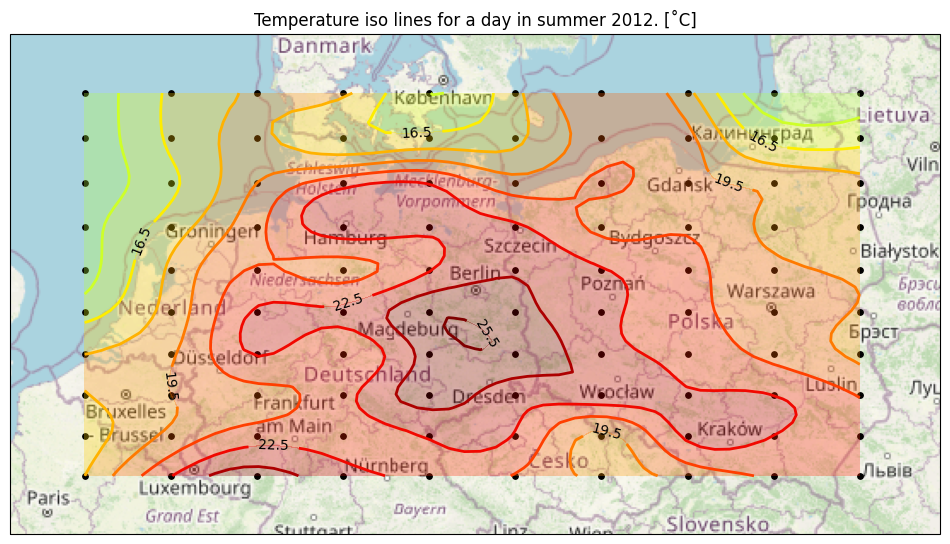

In [75]:
import scipy.ndimage
def smooth( array ):
    return scipy.ndimage.zoom( array, 5 )

fig = plt.figure(figsize=(12,8)) # open matplotlib figure
ax1 = plt.axes( projection=osm_img.crs ) 

center_pt = [ 52.5145, 13.37 ] # lat/lon 
zoom = 12 # for zooming out of center point
extent = [center_pt[1]-zoom,center_pt[1]+zoom,center_pt[0]-zoom/3,center_pt[0]+zoom/3.6] # adjust to zoom
ax1.set_extent(extent) # set extents
detail_level = 5 # OSM
ax1.add_image( osm_img, int( np.clip( detail_level, 0, 19 )) ) # add OSM with zoom specification

t = 24*30*6 + 8
s  = ax1.scatter( grid_lon, grid_lat, transform=ccrs.PlateCarree(), s=15, c="k" )
cf = ax1.contourf( smooth( grid_lon ), smooth( grid_lat ), smooth( augmented_data[t,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, alpha=0.3, cmap="jet", vmin=0,vmax=25)

cf = ax1.contour( smooth( grid_lon ), smooth( grid_lat ), smooth( augmented_data[t,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, cmap="jet", linewidths=2, vmin=0,vmax=25)

try:
    ax1.clabel(cf, cf.levels[::2], inline=True, inline_spacing=10, fontsize=10, colors="k")
except:
    pass

plt.plot( [] )
plt.title( "Temperature iso lines for a day in summer 2012. [˚C]")
plt.show()

## Transform wind speed and direction to vektorial values:

In [9]:
wdir_index = 3
wspd_index = 4

In [10]:
def wind_to_vektor(data):
    augmented_data = data 
    for t in tqdm( range( len( data ) ) ):
        wdir = -data[t,:,:,wdir_index] * ( 2*np.pi / 360 )
        wspd =  data[t,:,:,wspd_index]
        vx = wspd * np.sin( wdir )
        vy = wspd * np.cos( wdir )
        augmented_data[t,:,:,wdir_index] = vx
        augmented_data[t,:,:,wspd_index] = vy
    return augmented_data

In [11]:
augmented_data = wind_to_vektor( augmented_data )

100%|███████████████████████████████████████████████| 96432/96432 [00:00<00:00, 164729.84it/s]


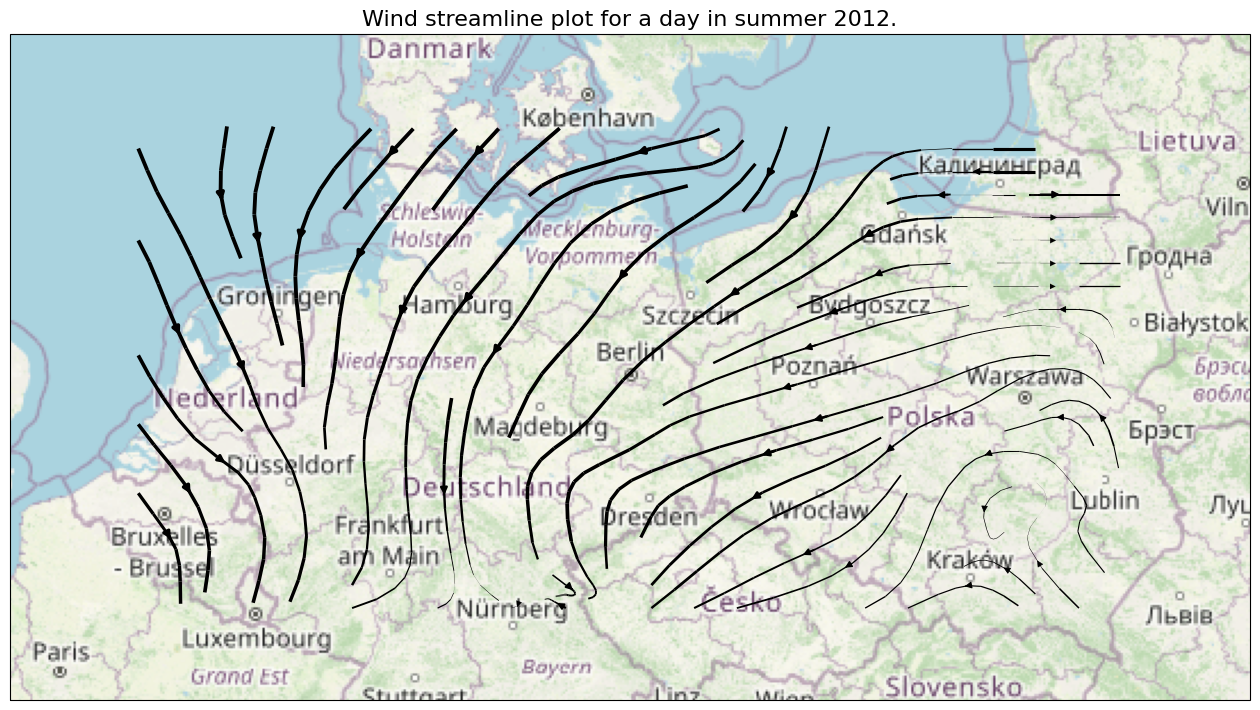

In [15]:
fig = plt.figure(figsize=(16,12)) # open matplotlib figure
ax1 = plt.axes( projection=osm_img.crs ) 
ax1.set_extent(extent) 
ax1.add_image( osm_img, int( np.clip( detail_level, 0, 19 )) )

t = 24*30*6

# line density from logarithmic wind speed:
lw = 0.5 * np.log( np.clip( augmented_data[t,:,:,wdir_index]**2 + augmented_data[t,:,:,wspd_index]**2, 0.01, 250 ) )

plt.streamplot( grid_lon, grid_lat, augmented_data[t,:,:,wdir_index], augmented_data[t,:,:,wspd_index], 
               linewidth=lw, transform=ccrs.PlateCarree(), zorder=20, color="k" )

# to me, barbs are not as informative, but they might be helpful for others:
#plt.barbs( grid_lon, grid_lat, augmented_data[t,:,:,wdir_index], augmented_data[t,:,:,wspd_index], 
#               transform=ccrs.PlateCarree(), zorder=20, color="b" )

plt.title( "Wind streamline plot for a day in summer 2012.", fontsize=16 )
plt.show()

In [12]:
def normalize( data ):
    data_mean = data.mean( axis=0 )
    data_std = data.std( axis=0 )
    return (data - data_mean) / data_std

In [13]:
augmented_data = normalize( augmented_data )

# Machine Learning part for weather prediction:
We use the Tensorflow library for it

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### The standart timeseries generator of Tensorflow blows up the memory a lot!
To circumvent this, we use a custom generator which yields array views to input and target data!  
The order of the data should not be linear in time, otherwise the learning can never generalize over months or seasons. 

In [15]:
class grid_timeseries_generator:
    """Custom generator that efficiently stores timeseries arrays and yields array views for learing."""
    def __init__(self, past_hours:int, future_hours:int, grid_data ):
        """ Construct grid_timeseries_generator object
        Params
        ======
            past_hours: hours of data in the input
            future_hours: hours of the forecast
            grid_data: 4D numpy tensor with the axes format: time (hours), x, y, channels
        """
        self.local_grid_data   = grid_data
        
        self.past = past_hours
        self.future = future_hours
        
    def __call__(self):
        """yield timeseries in random order."""
        order = np.arange( ( self.local_grid_data.shape[0] - self.past - self.future ) // 24 )
        np.random.shuffle( order )
        for i in order:
            i *= 24
            hours = np.s_[ i    : i + self.past ]
            future_hours = np.s_[ (i + self.past) : (i + self.past + self.future) ]
            
            # provide now state of the grid as separate input:
            # output mapping to temp, wind and pressure
            yield { "grid_past"  : self.local_grid_data[hours], \
                    "grid_now"   : self.local_grid_data[hours][-1], }, \
                   (self.local_grid_data[future_hours,:,:,:])

In [17]:
# create timeseries generator object, setting input data and target data to 3 days!
generator = grid_timeseries_generator( 3*24, 3*24, augmented_data )

# create Tensorflow dataset from our object
full_dataset = tf.data.Dataset.from_generator( generator, output_types=({ "grid_past" : tf.float32,  
                                                                          "grid_now" : tf.float32,},
                                                                         (tf.float32) ))
dataset = full_dataset.batch(64)
dataset_size = len( [ _ for _ in dataset ] )

# Now build a neural network:

We build an encoder that work similar to a model working on videos. 
In this sence we employ time resolved image recognition  
of the temperature and other fields. 
### Encoder
The DepthwieseConv2D layer uses a different convolutional kernel for all input observables.  
Additionally, we use MaxPooling layers. 
### Recurrent layer
For the time encoding we use a recurrent GRU/Long Short Term Memory layer.  
Temporal trends are better detected when the layer output is returned as a function of time.  
### Decoder
For the decoder, our first choice where Conv2DTranspose layers, 
however these didn't resolve the borders well.

In [18]:
def build_model( grid_size, channels, features, past, future ):
    """ Creates tensorflow model 
        Params
        ======
            grid_size: length of the 2D input grid
            channels: number of input data channels
            features: features represented in the output of the model
            past: hours of data
            future: hours of forecast
    """
    grid_past  = layers.Input((past,grid_size,grid_size,channels), name="grid_past") 
    grid_now   = layers.Input((grid_size,grid_size,channels), name="grid_now")
    
    # encoder for the grid state:
    grid_encoder = layers.TimeDistributed( layers.LocallyConnected2D( channels, (3,3) ), name="local2D_1" )( grid_past )
    grid_encoder = layers.TimeDistributed( layers.MaxPooling2D(), name="max_pooling_1" )( grid_encoder )
    grid_encoder = layers.TimeDistributed( layers.LocallyConnected2D( channels, (3,3) ), name="local2D_2" )( grid_encoder )
    grid_encoder = layers.TimeDistributed( layers.MaxPooling2D(), name="max_pooling_2" )( grid_encoder )
    grid_encoder = layers.TimeDistributed( layers.Flatten() )( grid_encoder )
    
    # recurrent network for the temporal dynamics:
    time_encoder = layers.LSTM( 64, name="recurrent", return_sequences=True )( grid_encoder ) 
    time_encoder = layers.TimeDistributed( layers.Dense( 32 ) )( time_encoder )
    time_encoder = layers.Flatten()( time_encoder )
    
    # merge with the grid state of current weather state:
    merge_layer_grid = layers.Concatenate(name="concat")( [ time_encoder, layers.Flatten()( grid_now ) ] )   
    
    # decoder: 
    output_grid = layers.Dense( future*(grid_size-2)*(grid_size-2)*features )( merge_layer_grid )
    output_grid = layers.Reshape( (future,(grid_size-2),(grid_size-2),features) )( output_grid )
    output_grid = layers.TimeDistributed( tf.keras.layers.Conv2DTranspose( features, 4, input_shape=(8,8,1) ), name="upscaler"  )( output_grid )
    output_grid = layers.TimeDistributed( layers.LocallyConnected2D( features, (2,2) ), name="local_out" )( output_grid )
  
    return keras.Model( [grid_past,grid_now], [output_grid] )

# We introduce additional optimization and metric functions:
For our understanding it is useful to use the temperature deviation as metric.   

In [19]:
# mean absolute temperature deviation:
def temp_mae( y, y_true ):
    mae = tf.reduce_mean( tf.abs( y[:,:,:,:,0] - y_true[:,:,:,:,0] ) )
    return mae

# To help the model to generalize, we define an additional physics loss:

This instroduces a physics informed neural network (PINN).  
First, we hint that the temperature field may show heat conduction to some extent.  
Of course the dissipation and conduction is inhomogeneous and unknown.  
Thus, we suggest that the predicted field should obey the heat equation to the same extent as the input field.
  
Also, we suggest that temperatuer and velocity fields should obey some remainder  
of the incompressible Euler equation without pressure gradient (for now).

In [20]:
def my_loss( y, y_true ):
    """Compute custom loss function including a physics loss."""
    
    transpose = lambda x : tf.transpose( x, (0,2,3,1) )

    # Heat conduction physics loss:
    y -= y_true
    dTdt = transpose( y[:,2:,:,:,0] - y[:,:-2,:,:,0] ) * 10 # inverse heat conductivity
    dTdx, dTdy = tf.image.image_gradients( transpose( y[:,1:-1,:,:,0] ) )
    dTdx2, _   = tf.image.image_gradients( dTdx )
    _, dTdy2   = tf.image.image_gradients( dTdy )
    physics_loss = tf.reduce_mean( tf.square( dTdx2 + dTdy2 - dTdt ) )
    
    # velocity field indices:
    u_idx, v_idx = 1, 2 
    
    # Euler equation, but with zero pressure gradient:
    dUdt = transpose( y[:,2:,:,:,u_idx] - y[:,:-2,:,:,u_idx] ) 
    dVdt = transpose( y[:,2:,:,:,v_idx] - y[:,:-2,:,:,v_idx] ) 
    dUdx, dUdy = tf.image.image_gradients( transpose( y[:,1:-1,:,:,u_idx] ) )
    dVdx, dVdy = tf.image.image_gradients( transpose( y[:,1:-1,:,:,v_idx] ) )
    LU = dUdt + ( transpose( y[:,1:-1,:,:,u_idx] ) * dUdx + transpose( y[:,1:-1,:,:,v_idx] ) * dUdy )
    LV = dVdt + ( transpose( y[:,1:-1,:,:,u_idx] ) * dVdx + transpose( y[:,1:-1,:,:,v_idx] ) * dVdy )
    physics_loss += tf.reduce_mean( tf.square( LU ) ) + tf.reduce_mean( tf.square( LV ) )  
    
    mse = tf.reduce_mean( tf.square( y ) )
    return mse + 1e-3 *  physics_loss

# Compiling and Training:

In [21]:
model = build_model( augmented_data.shape[1], augmented_data.shape[-1], augmented_data.shape[-1], 72, 72 )

In [22]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss = [my_loss],
    metrics = [[temp_mae,"mse"]]
)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 grid_past (InputLayer)         [(None, 72, 10, 10,  0           []                               
                                 6)]                                                              
                                                                                                  
 local2D_1 (TimeDistributed)    (None, 72, 8, 8, 6)  21120       ['grid_past[0][0]']              
                                                                                                  
 max_pooling_1 (TimeDistributed  (None, 72, 4, 4, 6)  0          ['local2D_1[0][0]']              
 )                                                                                                
                                                                                              

In [23]:
history = model.fit( dataset.take( int( 0.7 * dataset_size )),
           validation_data=dataset.take( int( 0.3 * dataset_size )),
           callbacks=[keras.callbacks.EarlyStopping(patience=10)],
           epochs=150 );

Epoch 1/150


2023-03-09 13:54:18.424095: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'my_loss/cond/output/_10'
2023-03-09 13:54:18.433850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 13:54:19.028452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 13:54:20.223216: I 

     44/Unknown - 12s 163ms/step - loss: 0.5447 - temp_mae: 0.3596 - mse: 0.5416

2023-03-09 13:54:28.663118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 13:54:29.037123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 15s 238ms/step - loss: 0.5447 - temp_mae: 0.3596 - mse: 0.5416 - val_loss: 0.4671 - val_temp_mae: 0.2861 - val_mse: 0.4647
Epoch 2/150
44/44 [==============================] - 8s 182ms/step - loss: 0.4608 - temp_mae: 0.2822 - mse: 0.4584 - val_loss: 0.4516 - val_temp_mae: 0.2778 - val_mse: 0.4493
Epoch 3/150
44/44 [==============================] - 8s 183ms/step - loss: 0.4482 - temp_mae: 0.2758 - mse: 0.4459 - val_loss: 0.4442 - val_temp_mae: 0.2693 - val_mse: 0.4419
Epoch 4/150
44/44 [==============================] - 8s 180ms/step - loss: 0.4470 - temp_mae: 0.2720 - mse: 0.4447 - val_loss: 0.4477 - val_temp_mae: 0.2732 - val_mse: 0.4455
Epoch 5/150
44/44 [==============================] - 8s 180ms/step - loss: 0.4427 - temp_mae: 0.2715 - mse: 0.4404 - val_loss: 0.4366 - val_temp_mae: 0.2672 - val_mse: 0.4343
Epoch 6/150
44/44 [==============================] - 8s 179ms/step - loss: 0.4372 - temp_mae: 0.2706 - mse: 0.4349 - val_loss: 0.4343 - 

Epoch 48/150
44/44 [==============================] - 8s 182ms/step - loss: 0.2165 - temp_mae: 0.1973 - mse: 0.2149 - val_loss: 0.2063 - val_temp_mae: 0.1942 - val_mse: 0.2047
Epoch 49/150
44/44 [==============================] - 8s 181ms/step - loss: 0.2125 - temp_mae: 0.1966 - mse: 0.2109 - val_loss: 0.1989 - val_temp_mae: 0.1975 - val_mse: 0.1974
Epoch 50/150
44/44 [==============================] - 8s 181ms/step - loss: 0.2039 - temp_mae: 0.1942 - mse: 0.2023 - val_loss: 0.1928 - val_temp_mae: 0.1861 - val_mse: 0.1913
Epoch 51/150
44/44 [==============================] - 8s 182ms/step - loss: 0.2017 - temp_mae: 0.1933 - mse: 0.2001 - val_loss: 0.1927 - val_temp_mae: 0.1867 - val_mse: 0.1912
Epoch 52/150
44/44 [==============================] - 8s 182ms/step - loss: 0.2003 - temp_mae: 0.1914 - mse: 0.1988 - val_loss: 0.1863 - val_temp_mae: 0.1846 - val_mse: 0.1848
Epoch 53/150
44/44 [==============================] - 8s 182ms/step - loss: 0.1964 - temp_mae: 0.1921 - mse: 0.1949 - va

44/44 [==============================] - 8s 183ms/step - loss: 0.1377 - temp_mae: 0.1621 - mse: 0.1364 - val_loss: 0.1339 - val_temp_mae: 0.1578 - val_mse: 0.1327
Epoch 95/150
44/44 [==============================] - 8s 187ms/step - loss: 0.1383 - temp_mae: 0.1622 - mse: 0.1370 - val_loss: 0.1365 - val_temp_mae: 0.1613 - val_mse: 0.1352
Epoch 96/150
44/44 [==============================] - 8s 183ms/step - loss: 0.1386 - temp_mae: 0.1631 - mse: 0.1373 - val_loss: 0.1298 - val_temp_mae: 0.1568 - val_mse: 0.1286
Epoch 97/150
44/44 [==============================] - 8s 184ms/step - loss: 0.1358 - temp_mae: 0.1615 - mse: 0.1345 - val_loss: 0.1288 - val_temp_mae: 0.1548 - val_mse: 0.1276
Epoch 98/150
44/44 [==============================] - 8s 184ms/step - loss: 0.1356 - temp_mae: 0.1625 - mse: 0.1343 - val_loss: 0.1292 - val_temp_mae: 0.1576 - val_mse: 0.1280
Epoch 99/150
44/44 [==============================] - 8s 187ms/step - loss: 0.1361 - temp_mae: 0.1620 - mse: 0.1348 - val_loss: 0.126

(0.1, 0.6)

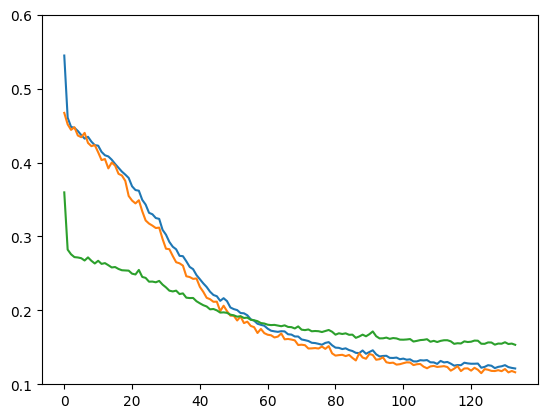

In [24]:
plt.plot( history.history["loss"] )
plt.plot( history.history["val_loss"] )
plt.plot( history.history["temp_mae"] )
plt.ylim(0.1, 0.6 )

# Now we want to see how the model performs on the map!
## We begin by plotting the temperature field in steps of 12 hours:

1/1 [==============================] - 0s 32ms/step


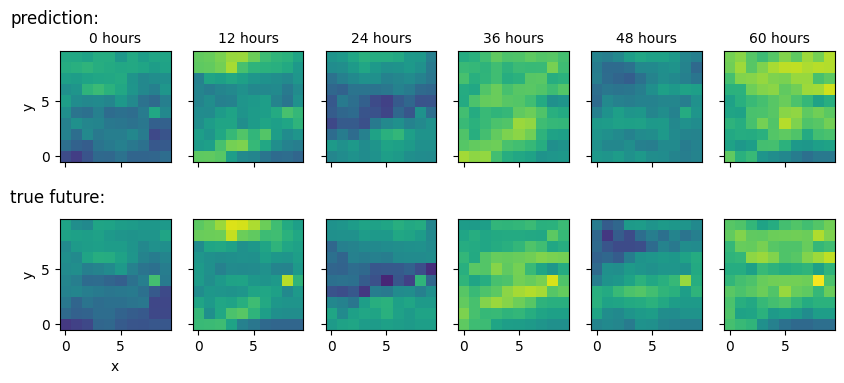

In [35]:
fig, axes = plt.subplots( 2, 6, sharey=True, sharex=True, figsize=(10, 4) )
temp_idx = 0

# Take a single batch of size one, ie. one realization:
for x, (y) in full_dataset.batch(1).take(1):
    y_pred = model.predict( x )
    vmin = np.min( y[0,:,:,:,temp_idx] ) # indices: batch, time, x, y, channels  
    vmax = np.max( y[0,:,:,:,temp_idx] )
    
    # plot development over time:
    for j in range( 0,6 ):
        axes[0,j].set_title( "%i hours"%(j*12), fontsize=10 )
        axes[0,j].imshow( y_pred[0,j*12,:,:,temp_idx], origin="lower", vmin=vmin, vmax=vmax )
        axes[1,j].imshow( y[0,j*12,:,:,temp_idx],      origin="lower", vmin=vmin, vmax=vmax )
        
axes[0,0].text( -5, 12, "prediction:", fontsize=12 );
axes[1,0].text( -5, 11, "true future:", fontsize=12 );     
axes[0,0].set_ylabel("y")
axes[1,0].set_ylabel("y")
axes[1,0].set_xlabel("x");

What do we see here, how ist the performance ?

# Prediction over time at the center of the region of interest:

1/1 [==============================] - 0s 34ms/step


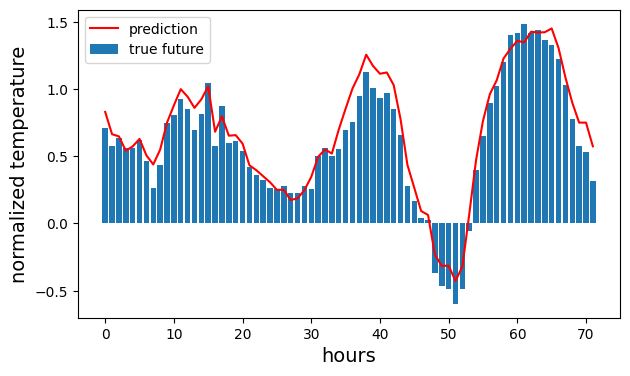

In [30]:
fig, axes = plt.subplots( 1, 1, figsize=(7, 4) )
for x, (y) in full_dataset.batch(1).take(1):
    y_pred = model.predict( x )
    axes.bar( range( len(y[0,:,0,0,0] )), y[0,:,5,5,0], label="true future" )
    axes.plot( y_pred[0,:,5,5,0], c="r", label="prediction" )
    
axes.set_ylabel("normalized temperature", fontsize=14)
axes.set_xlabel("hours", fontsize=14)
axes.legend();

# Prediction over time at the border:

We see that the model correctly captures a daily trend and also the development over the course of a few days.

1/1 [==============================] - 0s 48ms/step


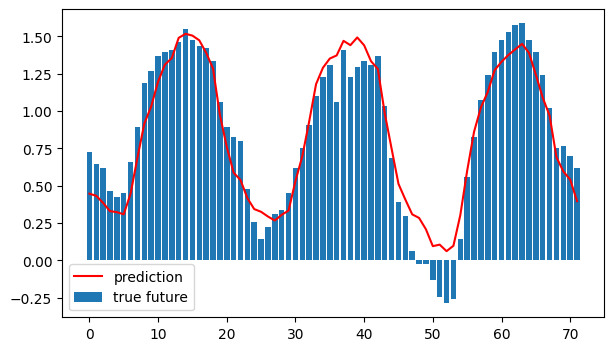

In [31]:
fig, axes = plt.subplots( 1, 1, figsize=(7, 4) )
for x, (y) in full_dataset.batch(1).take(1):
    y_pred = model.predict( x )
    axes.bar( range( len(y[0,:,0,0,0] )), y[0,:,0,0,0], label="true future" )
    axes.plot( y_pred[0,:,0,0,0], c="r", label="prediction" )
    
axes.legend();

In [32]:
import scipy.ndimage
def smooth( array ):
    return scipy.ndimage.zoom( array, 5 )

center_pt = [ 52.5145, 13.37 ] # lat/lon 
zoom = 12 # for zooming out of center point
extent = [center_pt[1]-zoom,center_pt[1]+zoom,center_pt[0]-zoom/3,center_pt[0]+zoom/3.6] # adjust to zoom

1/1 [==============================] - 0s 33ms/step
0.005775183439254761   2.190358430147171


100%|█████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]


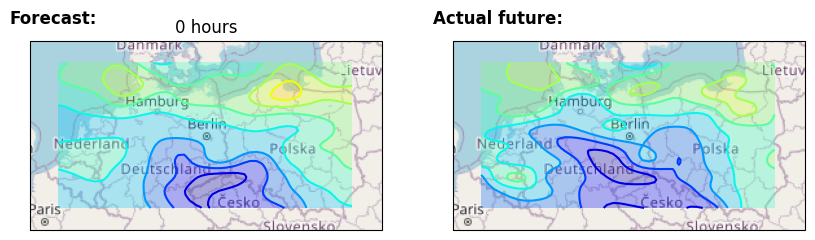

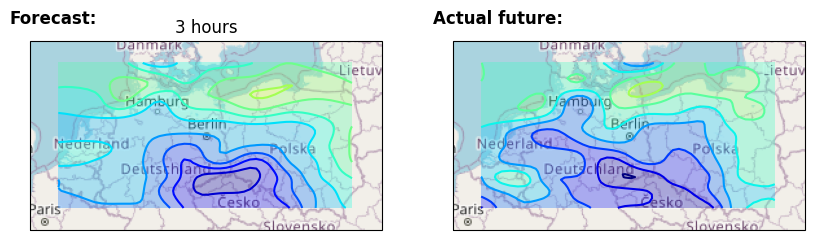

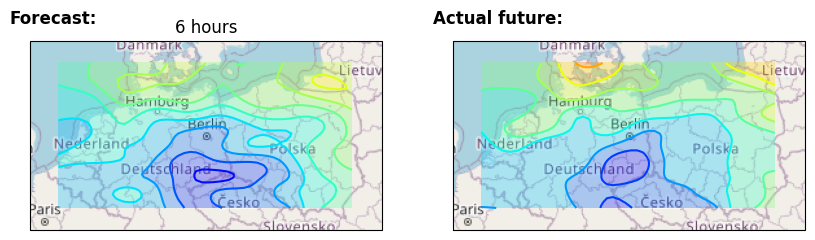

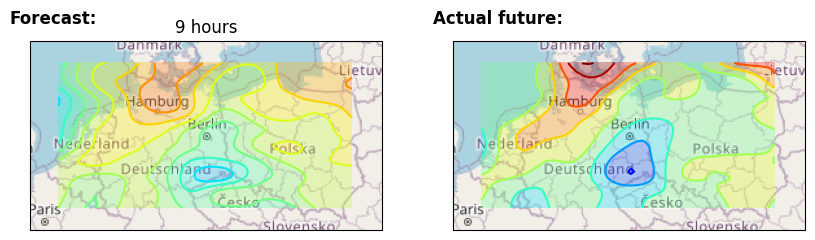

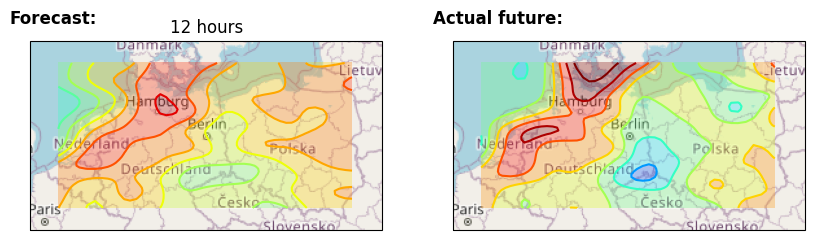

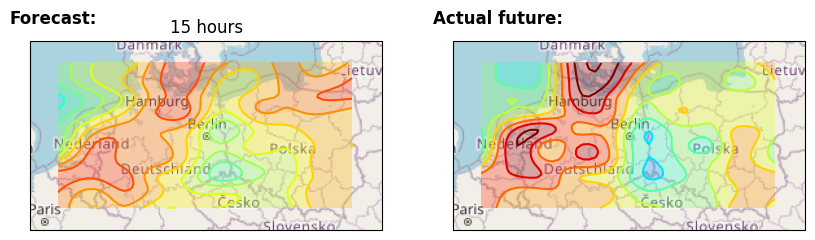

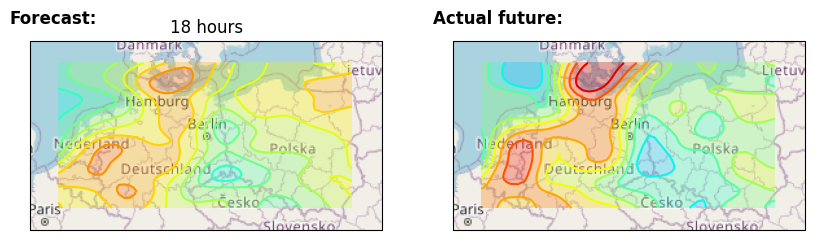

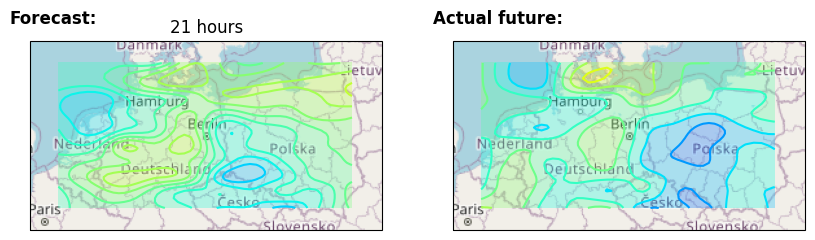

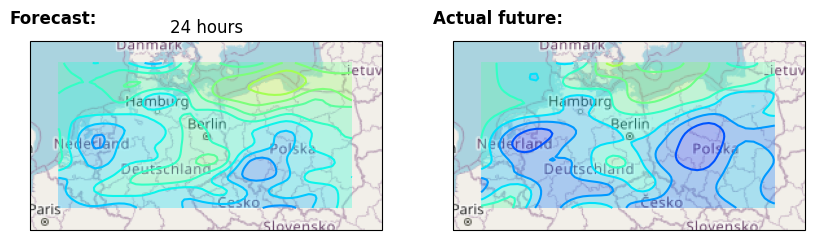

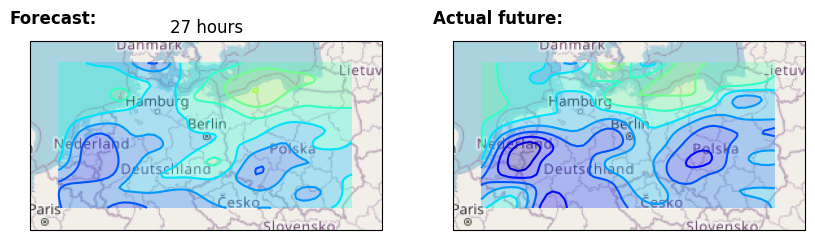

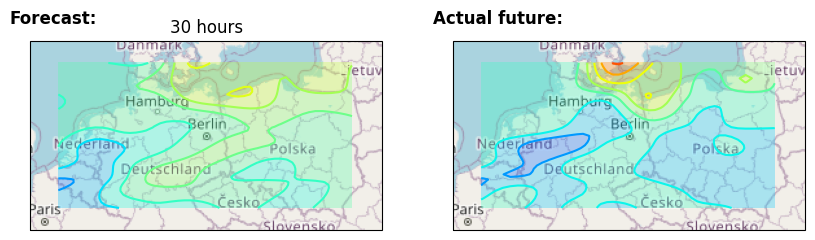

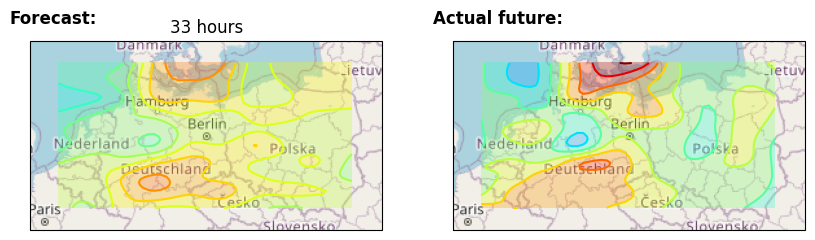

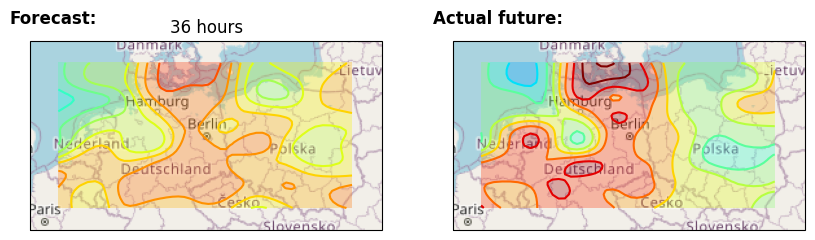

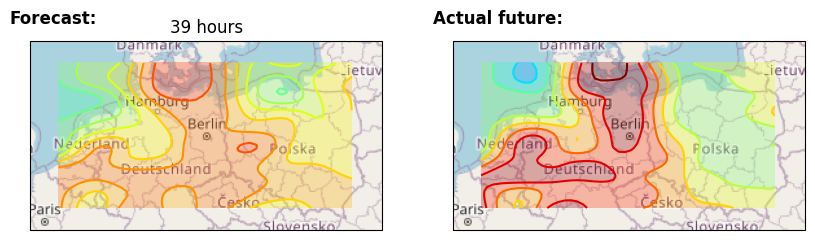

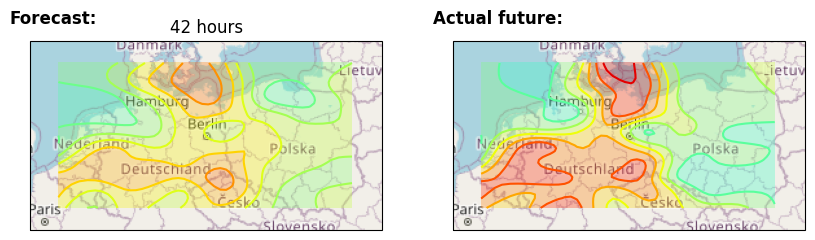

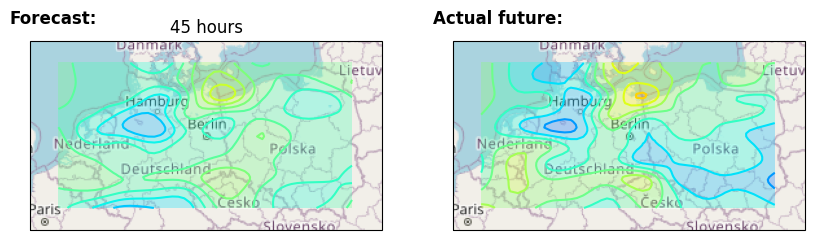

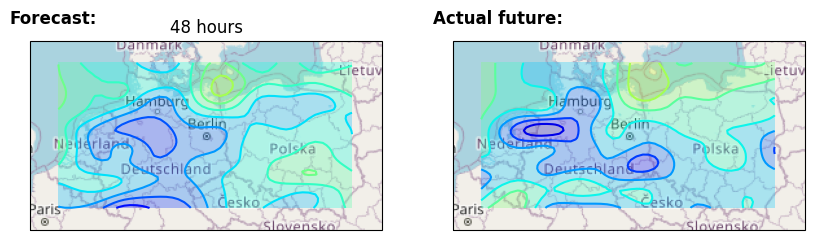

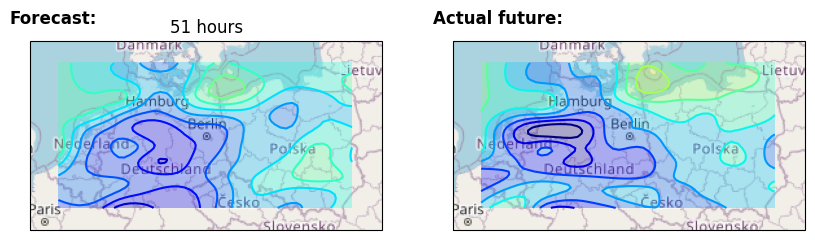

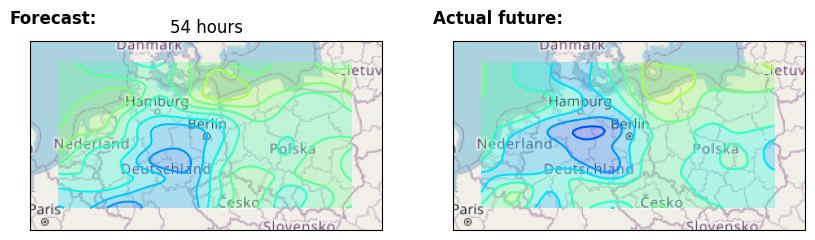

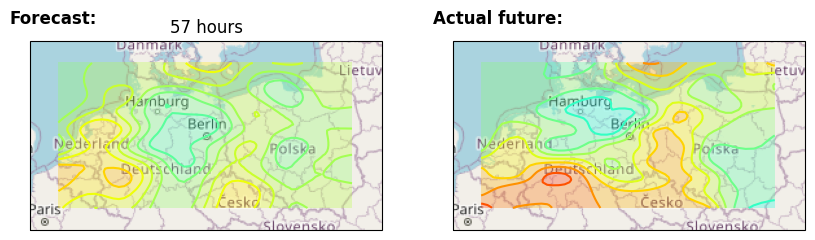

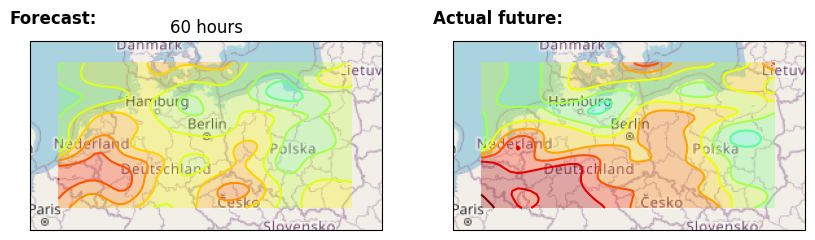

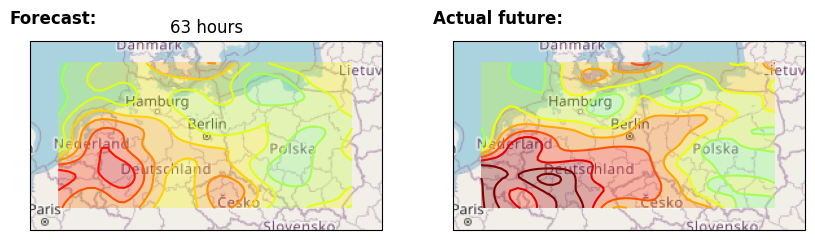

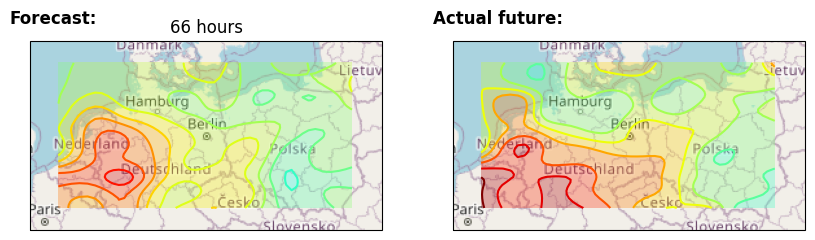

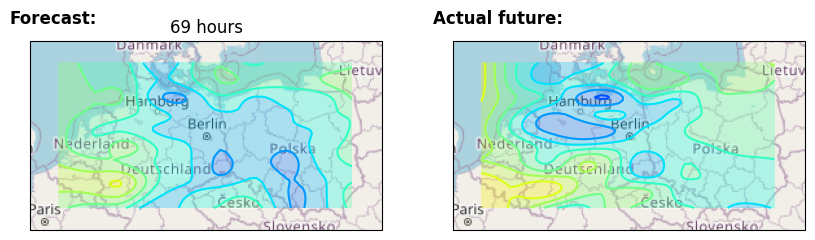

In [150]:
# Take a single batch of size one, ie. one realization:
for x, (y) in full_dataset.batch(1).take(1):
    y_pred = model.predict( x )
    vmin = np.mean( y[0,:,:,:,0] ) - 2.5 * np.std( y[0,:,:,:,0] )
    vmax = np.mean( y[0,:,:,:,0] ) + 2.5 * np.std( y[0,:,:,:,0] )
    print( vmin," ", vmax )
    
    # plot development over time:
    for j in tqdm( range( 0,72,3 ) ):
        fig, axes = plt.subplots( 1, 2, sharey=True, sharex=True, figsize=(10, 5), 
                         subplot_kw={'projection': osm_img.crs} )
        
        axes[0].set_extent(extent) # set extents
        axes[0].add_image( osm_img, 4 ) # add OSM with zoom specification
        axes[1].set_extent(extent) # set extents
        axes[1].add_image( osm_img, 4 ) # add OSM with zoom specification
        
        axes[0].set_title( "%i hours"%j, fontsize=12 )
        cf = axes[0].contourf( smooth( grid_lon ), smooth( grid_lat ), smooth( y_pred[0,j,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, alpha=0.3, cmap="jet", vmin=-vmin,vmax=vmax)

        cf = axes[0].contour( smooth( grid_lon ), smooth( grid_lat ), smooth( y_pred[0,j,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, cmap="jet", linewidths=1.5, vmin=-vmin,vmax=vmax)
        
        cf = axes[1].contourf( smooth( grid_lon ), smooth( grid_lat ), smooth( y[0,j,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, alpha=0.3, cmap="jet", vmin=-vmin,vmax=vmax)

        cf = axes[1].contour( smooth( grid_lon ), smooth( grid_lat ), smooth( y[0,j,:,:,0] ),
                  transform=ccrs.PlateCarree(), extent=extent, cmap="jet", linewidths=1.5, vmin=-vmin,vmax=vmax)
        
        axes[0].text( 0, 57, "Forecast:",  fontsize=12, fontweight="bold", transform=ccrs.PlateCarree() );
        axes[1].text( 0, 57, "Actual future:", fontsize=12, fontweight="bold", transform=ccrs.PlateCarree(), 
                         zorder=20, backgroundcolor="w" );     
        plt.savefig( "frame_%03i"%(j//3), bbox_inches="tight" )